In [1]:
import wfdb
import pywt

import os
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split as tts
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import KFold


import pickle

In [5]:
wfdb.dl_database('mitdb', dl_dir = 'mit_bih')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [2]:
input_dir = 'mit_bih/*.atr'
ecg_data = sorted([os.path.splitext(i)[0] for i in glob(input_dir)])

In [3]:
classes = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
sub = {'N':'N', 'L':'N', 'R':'N', 'e':'N', 'j':'N', 
        'A':'S', 'a':'S', 'J':'S', 'S':'S',
        'V':'V', 'E':'V',
        'F':'F',
        '/':'Q', 'f':'Q', 'Q':'Q'}

In [4]:
def  denoise (data):
    # Wavelet transform
    coeffs = pywt.wavedec(data, 'db8', level = 9)
    cA9, cD9,cD8, cD7, cD6, cD5, cD4,cD3, cD2, cD1 = coeffs
    
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(data))))

    for  i  in  range ( 1 , len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    return pywt.waverec(coeffs, 'db8')


In [5]:
def hb_segmentation(ecg, _denoise= False):
    signals = []
    labels = []

    record = wfdb.rdrecord(ecg)
    ann = wfdb.rdann(ecg, extension = 'atr')

    for sig_name, signal in zip(record.sig_name, record.p_signal.T):
        
        if sig_name == 'MLII':
            signal = scale(signal)
            
            for i, (label, R) in enumerate(zip(ann.symbol, ann.sample)):

                if label in sub.keys():
                    enc_label = sub[label]
                    enc_label = classes[enc_label]
                    l, r = R - 90, R + 190

                    if np.all([l > 0, r < len(signal)]):
                        f = signal[l: r].tolist()

                        if _denoise:
                            #f, cD3, cD2, cD1 = pywt.wavedec(f, 'db4', level = 3)
                            f = denoise(f)
                        labels.append(enc_label)
                        signals.append(f)

    return (signals, labels)

In [6]:
X = []
y = []

for i in ecg_data:
    a, b = hb_segmentation(i, True)
    X.extend(a)
    y.extend(b)
del a, b
X = np.array(X)
y = np.array(y)

C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(
C:\Users\rohan\AppData\Local\Programs\Python\Python38\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience 

In [7]:
X.shape, y.shape

((105038, 280), (105038,))

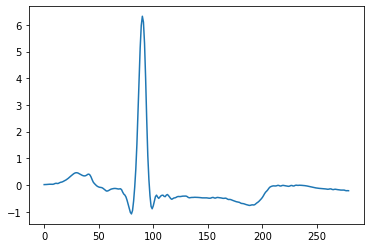

In [8]:
plt.plot(X[0])

In [9]:
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3)

In [10]:
clas = SVC()

In [ ]:
clas.fit(X_train, y_train)

In [17]:
y_pred = clas.predict(X_test)

In [18]:
accuracy_score(y_test, y_pred)

0.9802297537446052

<AxesSubplot:>

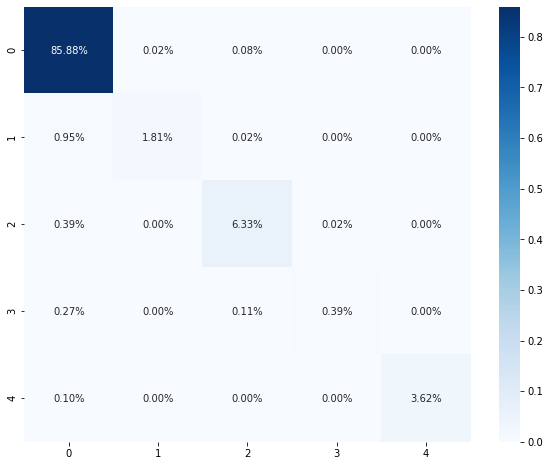

In [19]:
plt.rcParams['figure.figsize'] = (10, 8)
sns.heatmap(confusion_matrix(y_test, y_pred) / np.sum(confusion_matrix(y_test, y_pred)), cmap = 'Blues', annot = True, fmt = '.2%' )

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27095
           1       0.99      0.65      0.78       877
           2       0.97      0.94      0.95      2125
           3       0.95      0.50      0.66       242
           4       1.00      0.97      0.99      1173

    accuracy                           0.98     31512
   macro avg       0.98      0.81      0.87     31512
weighted avg       0.98      0.98      0.98     31512



In [30]:
unique, counts = np.unique(y_train, return_counts = True)
print(unique, counts)

[0 1 2 3 4] [63236  1904  5104   560  2722]


In [44]:
# class_weight = {0: 1,
#                 1: 70,
#                 2: 30,
#                 3: 100,
#                 4: 50}

In [12]:
clas2 = RandomForestClassifier()
clas2.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
y_pred2 = clas2.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred2)

0.9804201574003554

In [15]:
confusion_matrix(y_test, y_pred2)

array([[27068,    27,    25,     2,     4],
       [  267,   565,     4,     0,     0],
       [  130,     0,  2008,     7,     2],
       [   98,     0,    20,   110,     0],
       [   30,     0,     1,     0,  1144]], dtype=int64)

In [16]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27126
           1       0.95      0.68      0.79       836
           2       0.98      0.94      0.96      2147
           3       0.92      0.48      0.63       228
           4       0.99      0.97      0.98      1175

    accuracy                           0.98     31512
   macro avg       0.97      0.81      0.87     31512
weighted avg       0.98      0.98      0.98     31512



<h2><b>Trying Over Sampling

In [17]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek()

X_train_re_smap, y_train_re_samp = smt.fit_resample(X_train, y_train)

KeyboardInterrupt: 